In [1]:
import argparse
import os
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
# import acc and mcc
from sklearn.metrics import accuracy_score as ACC
from sklearn.metrics import matthews_corrcoef as MCC
import itertools
import seaborn as sns
os.chdir('../')


In [2]:
from matplotlib import rcParams, cycler
def calculate_mcc_per_bact(df, bacteria_cols):
    mcc = {}
    mccs = {b: [] for b in bacteria_cols}
    mccs_cv = {b: [] for b in bacteria_cols}
    for bacterium in bacteria_cols:
        tmp = df.copy()
        tmp['labels'] = tmp['labels'].apply(lambda x: 1 if x == bacterium else 0)
        tmp['preds'] = tmp['preds'].apply(lambda x: 1 if x == bacterium else 0)
        mcc[bacterium] = MCC(tmp['labels'], tmp['preds'])
    for bacterium in bacteria_cols:
        for batch in df['batches'].unique():
            tmp = df.copy()
            tmp = tmp[tmp['batches'] == batch]
            if bacterium in tmp['labels'].unique():
                tmp['labels'] = tmp['labels'].apply(lambda x: 1 if x == bacterium else 0)
                tmp['preds'] = tmp['preds'].apply(lambda x: 1 if x == bacterium else 0)
                mccs[bacterium] += [MCC(tmp['labels'], tmp['preds'])]
    for bacterium in bacteria_cols:
        for cv in df['cv'].unique():
            tmp = df.copy()
            tmp = tmp[tmp['cv'] == cv]
            if bacterium in tmp['labels'].unique():
                tmp['labels'] = tmp['labels'].apply(lambda x: 1 if x == bacterium else 0)
                tmp['preds'] = tmp['preds'].apply(lambda x: 1 if x == bacterium else 0)
                mccs_cv[bacterium] += [MCC(tmp['labels'], tmp['preds'])]
    return mcc, mccs, mccs_cv

def calculate_mcc_per_batch(df, batches):
    mcc = {}
    mccs = {b: [] for b in batches}
    mccs_cv = {b: [] for b in batches}
    for batch in batches:
        tmp = df.copy().iloc[df[df['batches'] == batch].index]
        mcc[batch] = MCC(tmp['labels'], tmp['preds'])
    for batch in batches:
        # for bacterium in df['labels'].unique():
        tmp = df.copy()
        tmp = tmp[tmp['batches'] == batch]
        # if bacterium in tmp['labels'].unique():
        # tmp['labels'] = tmp['labels']#.apply(lambda x: 1 if x == bacterium else 0)
        # tmp['preds'] = tmp['preds']#.apply(lambda x: 1 if x == bacterium else 0)
        mccs[batch] += [MCC(tmp['labels'], tmp['preds'])]
    for batch in batches:
        for cv in df['cv'].unique():
            tmp = df.copy()
            tmp = tmp[tmp['cv'] == cv]
            # if bacterium in tmp['labels'].unique():
            # tmp['labels'] = tmp['labels']#.apply(lambda x: 1 if x == bacterium else 0)
            # tmp['preds'] = tmp['preds']#.apply(lambda x: 1 if x == bacterium else 0)
            mccs_cv[batch] += [MCC(tmp['labels'], tmp['preds'])]
    return mcc, mccs, mccs_cv

def make_graph(metrics, metric, category, cols, title, path):
    # Prepare data for plotting
    print('No cv')
    metric_df = pd.DataFrame({
        category: cols,
        'Valid': [metrics['valid'][b] for b in cols],
        'Test': [metrics['test'][b] for b in cols]
    })

    metric_melted_df = metric_df.melt(id_vars=category, var_name='Group', value_name=metric)

    # Plot metric by bacterium
    plt.figure(figsize=(14, 8))
    sns.barplot(x=category, y=metric, hue='Group', data=metric_melted_df)
    for i, bacterium in enumerate(cols):
        # Add errorbars for each bacterium
        
        plt.errorbar(i - 0.2, metrics['valid'][bacterium], yerr=([0], [np.std(metrics['valids'][bacterium])]), fmt='', color='black', capsize=5)
        plt.errorbar(i + 0.2, metrics['test'][bacterium], yerr=([0], [np.std(metrics['tests'][bacterium])]), fmt='', color='black', capsize=5)
        # Add a scatter plot for each bacterium
        plt.scatter([i - 0.2 + np.random.uniform(-0.02, 0.02) for _ in range(len(metrics['valids'][bacterium]))], metrics['valids'][bacterium], color='black', s=(rcParams['lines.markersize'] ** 2)/3)
        plt.scatter([i + 0.2 + np.random.uniform(-0.02, 0.02) for _ in range(len(metrics['tests'][bacterium]))], metrics['tests'][bacterium], color='black', s=(rcParams['lines.markersize'] ** 2)/3)
    plt.xticks(rotation=90)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(f'{path}.png')
    plt.close()

    print('CV')
    # Plot metric by bacterium
    plt.figure(figsize=(14, 8))
    sns.barplot(x=category, y=metric, hue='Group', data=metric_melted_df)
    for i, bacterium in enumerate(cols):
        # Add errorbars for each bacterium
        
        plt.errorbar(i - 0.2, metrics['valid'][bacterium], yerr=([0], [np.std(metrics['valid_cv'][bacterium])]), fmt='', color='black', capsize=5)
        plt.errorbar(i + 0.2, metrics['test'][bacterium], yerr=([0], [np.std(metrics['test_cv'][bacterium])]), fmt='', color='black', capsize=5)
        # Add a scatter plot for each bacterium
        plt.scatter([i - 0.2 + np.random.uniform(-0.02, 0.02) for _ in range(len(metrics['valid_cv'][bacterium]))], metrics['valid_cv'][bacterium], color='black', s=(rcParams['lines.markersize'] ** 2)/2)
        plt.scatter([i + 0.2 + np.random.uniform(-0.02, 0.02) for _ in range(len(metrics['test_cv'][bacterium]))], metrics['test_cv'][bacterium], color='black', s=(rcParams['lines.markersize'] ** 2)/2)
    plt.xticks(rotation=90)
    plt.title(title)
    plt.tight_layout()
    plt.show()
    plt.close()

def make_total_graph_total_batch(valid_metrics, test_metrics, metric, title, path):
    # Prepare data for plotting
    metric_df = pd.DataFrame({
        'Batch': valid_metrics.keys(),
        'Valid': [valid_metrics[b] for b in valid_metrics.keys()],
        'Test': [test_metrics[b] for b in test_metrics.keys()]
    })

    metric_melted_df = metric_df.melt(id_vars='Batch', var_name='Group', value_name=metric)
    # Add a column Batches with only the sAME VALUE Batches
    metric_melted_df['Batches'] = 'Batches'

    # Plot metric by bacterium
    plt.figure(figsize=(6, 6))
    sns.boxplot(x='Batches', y=metric, hue='Group', data=metric_melted_df)
    # Remove x axis label
    plt.xlabel('')
    # Remove ticks
    plt.xticks([])
    plt.xticks(rotation=90)
    plt.title(title)
    plt.tight_layout()
    plt.show()
    plt.close()

def make_total_graph_total_bact(valid_metrics, test_metrics, metric, title, path, bacteria_cols):
    # Prepare data for plotting
    metric_df = pd.DataFrame({
        'Bacteria': bacteria_cols,
        'Valid': [valid_metrics[b] for b in bacteria_cols],
        'Test': [test_metrics[b] for b in bacteria_cols]
    })

    metric_melted_df = metric_df.melt(id_vars='Bacteria', var_name='Group', value_name=metric)
    metric_melted_df['Bacteria'] = 'Bacteria'

    # Plot metric by bacterium
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='Bacteria', y=metric, hue='Group', data=metric_melted_df)
    plt.xticks(rotation=90)
    plt.title(title)
    # Remove x axis label
    plt.xlabel('')
    # Remove ticks
    plt.xticks([])
    plt.tight_layout()
    plt.show()
    plt.close()



In [3]:
def calculate_mcc_per_bact(df, bacteria_cols):
    mcc = {}
    mccs = {b: [] for b in bacteria_cols}
    mccs_cv = {b: [] for b in bacteria_cols}
    for bacterium in bacteria_cols:
        tmp = df.copy()
        tmp['labels'] = tmp['labels'].apply(lambda x: 1 if x == bacterium else 0)
        tmp['preds'] = tmp['preds'].apply(lambda x: 1 if x == bacterium else 0)
        mcc[bacterium] = MCC(tmp['labels'], tmp['preds'])
    for bacterium in bacteria_cols:
        for batch in df['batches'].unique():
            tmp = df.copy()
            tmp = tmp[tmp['batches'] == batch]
            if bacterium in tmp['labels'].unique():
                tmp['labels'] = tmp['labels'].apply(lambda x: 1 if x == bacterium else 0)
                tmp['preds'] = tmp['preds'].apply(lambda x: 1 if x == bacterium else 0)
                mccs[bacterium] += [MCC(tmp['labels'], tmp['preds'])]
    for bacterium in bacteria_cols:
        for cv in df['cv'].unique():
            tmp = df.copy()
            tmp = tmp[tmp['cv'] == cv]
            if bacterium in tmp['labels'].unique():
                tmp['labels'] = tmp['labels'].apply(lambda x: 1 if x == bacterium else 0)
                tmp['preds'] = tmp['preds'].apply(lambda x: 1 if x == bacterium else 0)
                mccs_cv[bacterium] += [MCC(tmp['labels'], tmp['preds'])]
    return mcc, mccs, mccs_cv

def calculate_mcc_per_batch(df, batches):
    mcc = {}
    mccs = {b: [] for b in batches}
    mccs_cv = {b: [] for b in batches}
    for batch in batches:
        tmp = df.copy().iloc[df[df['batches'] == batch].index]
        mcc[batch] = MCC(tmp['labels'], tmp['preds'])
    for batch in batches:
        # for bacterium in df['labels'].unique():
        tmp = df.copy()
        tmp = tmp[tmp['batches'] == batch]
        # if bacterium in tmp['labels'].unique():
        # tmp['labels'] = tmp['labels']#.apply(lambda x: 1 if x == bacterium else 0)
        # tmp['preds'] = tmp['preds']#.apply(lambda x: 1 if x == bacterium else 0)
        mccs[batch] += [MCC(tmp['labels'], tmp['preds'])]
    for batch in batches:
        for cv in df['cv'].unique():
            tmp = df.copy()
            tmp = tmp[tmp['cv'] == cv]
            # if bacterium in tmp['labels'].unique():
            # tmp['labels'] = tmp['labels']#.apply(lambda x: 1 if x == bacterium else 0)
            # tmp['preds'] = tmp['preds']#.apply(lambda x: 1 if x == bacterium else 0)
            mccs_cv[batch] += [MCC(tmp['labels'], tmp['preds'])]
    return mcc, mccs, mccs_cv

def make_graph(metrics, metric, category, cols, title, path):
    # Prepare data for plotting
    metric_df = pd.DataFrame({
        category: cols,
        'Valid': [metrics['valid'][b] for b in cols],
        'Test': [metrics['test'][b] for b in cols]
    })

    metric_melted_df = metric_df.melt(id_vars=category, var_name='Group', value_name=metric)

    # Plot metric by bacterium
    plt.figure(figsize=(14, 8))
    sns.barplot(x=category, y=metric, hue='Group', data=metric_melted_df)
    for i, bacterium in enumerate(cols):
        # Add errorbars for each bacterium
        
        plt.errorbar(i - 0.2, metrics['valid'][bacterium], yerr=([0], [np.std(metrics['valids'][bacterium])]), fmt='', color='black', capsize=5)
        plt.errorbar(i + 0.2, metrics['test'][bacterium], yerr=([0], [np.std(metrics['tests'][bacterium])]), fmt='', color='black', capsize=5)
        # Add a scatter plot for each bacterium
        plt.scatter([i - 0.2 + np.random.uniform(-0.02, 0.02) for _ in range(len(metrics['valids'][bacterium]))], metrics['valids'][bacterium], color='black', s=(rcParams['lines.markersize'] ** 2)/3)
        plt.scatter([i + 0.2 + np.random.uniform(-0.02, 0.02) for _ in range(len(metrics['tests'][bacterium]))], metrics['tests'][bacterium], color='black', s=(rcParams['lines.markersize'] ** 2)/3)
    plt.xticks(rotation=90)
    plt.title(title)
    plt.tight_layout()
    # plt.savefig(f'{path}.png')
    plt.show()
    plt.close()

    # Plot metric by bacterium
    plt.figure(figsize=(14, 8))
    sns.barplot(x=category, y=metric, hue='Group', data=metric_melted_df)
    for i, bacterium in enumerate(cols):
        # Add errorbars for each bacterium
        
        plt.errorbar(i - 0.2, metrics['valid'][bacterium], yerr=([0], [np.std(metrics['valid_cv'][bacterium])]), fmt='', color='black', capsize=5)
        plt.errorbar(i + 0.2, metrics['test'][bacterium], yerr=([0], [np.std(metrics['test_cv'][bacterium])]), fmt='', color='black', capsize=5)
        # Add a scatter plot for each bacterium
        plt.scatter([i - 0.2 + np.random.uniform(-0.02, 0.02) for _ in range(len(metrics['valid_cv'][bacterium]))], metrics['valid_cv'][bacterium], color='black', s=(rcParams['lines.markersize'] ** 2)/2)
        plt.scatter([i + 0.2 + np.random.uniform(-0.02, 0.02) for _ in range(len(metrics['test_cv'][bacterium]))], metrics['test_cv'][bacterium], color='black', s=(rcParams['lines.markersize'] ** 2)/2)
    plt.xticks(rotation=90)
    plt.title(title)
    plt.tight_layout()
    plt.show()
    plt.close()

def make_total_graph_total_batch(valid_metrics, test_metrics, metric, title, path):
    # Prepare data for plotting
    metric_df = pd.DataFrame({
        'Batch': valid_metrics.keys(),
        'Valid': [valid_metrics[b] for b in valid_metrics.keys()],
        'Test': [test_metrics[b] for b in test_metrics.keys()]
    })

    metric_melted_df = metric_df.melt(id_vars='Batch', var_name='Group', value_name=metric)
    # Add a column Batches with only the sAME VALUE Batches
    metric_melted_df['Batches'] = 'Batches'

    # Plot metric by bacterium
    plt.figure(figsize=(6, 6))
    sns.boxplot(x='Batches', y=metric, hue='Group', data=metric_melted_df)
    # Remove x axis label
    plt.xlabel('')
    # Remove ticks
    plt.xticks([])
    plt.xticks(rotation=90)
    plt.title(title)
    plt.tight_layout()
    plt.show()
    plt.close()

def make_total_graph_total_bact(valid_metrics, test_metrics, metric, title, path, bacteria_cols):
    # Prepare data for plotting
    metric_df = pd.DataFrame({
        'Bacteria': bacteria_cols,
        'Valid': [valid_metrics[b] for b in bacteria_cols],
        'Test': [test_metrics[b] for b in bacteria_cols]
    })

    metric_melted_df = metric_df.melt(id_vars='Bacteria', var_name='Group', value_name=metric)
    metric_melted_df['Bacteria'] = 'Bacteria'

    # Plot metric by bacterium
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='Bacteria', y=metric, hue='Group', data=metric_melted_df)
    plt.xticks(rotation=90)
    plt.title(title)
    # Remove x axis label
    plt.xlabel('')
    # Remove ticks
    plt.xticks([])
    plt.tight_layout()
    plt.show()
    plt.close()



In [4]:
def plot_confusion_matrix(cm, class_names, acc, mcc):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
        cm (array, shape = [n, n]): a confusion matrix of integer classes
        class_names (array, shape = [n]): String names of the integer classes

    Returns:
        The figure of the confusion matrix
    """
    figure = plt.figure(figsize=(8, 8))
    cm_normal = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    cm_normal[np.isnan(cm_normal)] = 0
    plt.imshow(cm_normal, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"Confusion matrix (Acc: {np.round(np.mean(acc), 3)}, Mcc: {np.round(np.mean(mcc), 3)})")
    plt.colorbar()
    # plt.grid(b=None)
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Compute the labels from the normalized confusion matrix.
    # labels = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = 0.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm_normal[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color, fontsize=8)

    # plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return figure



In [5]:
def plot_bars(args, bacteria_cols):
    # Load the datasets
    path = f'results/multi/mz{args.mz}/rt{args.rt}/ms{args.ms_level}/' \
            f'{args.spd}spd/thr{args.threshold}/{args.train_on}/{args.exp_name}/' \
            f'{args.model_name}/saved_models/'
    valid_df = pd.read_csv(f'{path}/{args.model_name}_valid_individual_results.csv', index_col=0)
    test_df = pd.read_csv(f'{path}/{args.model_name}_test_individual_results.csv', index_col=0)

    for metric in ['MCC']:
        if metric == 'MCC':
            total_valid = MCC(valid_df['labels'], valid_df['preds'])
            total_test = MCC(test_df['labels'], test_df['preds'])
            valid_metrics_bact, valid_metrics_bacts, valid_metrics_bacts_cv = calculate_mcc_per_bact(valid_df, bacteria_cols)
            test_metrics_bact, test_metrics_bacts, test_metrics_bacts_cv = calculate_mcc_per_bact(test_df, bacteria_cols)
            valid_metrics_batch, valid_metrics_batchs, valid_metrics_batch_cv = calculate_mcc_per_batch(valid_df, valid_df['batches'].unique())
            test_metrics_batch, test_metrics_batchs, test_metrics_batch_cv = calculate_mcc_per_batch(test_df, test_df['batches'].unique())

        metrics_bact = {
            'valid': valid_metrics_bact,
            'test': test_metrics_bact,
            'valids': valid_metrics_bacts,
            'tests': test_metrics_bacts,
            'valid_cv': valid_metrics_bacts_cv,
            'test_cv': test_metrics_bacts_cv,
        }
        metrics_batch = {
            'valid': valid_metrics_batch,
            'test': test_metrics_batch,
            'valids': valid_metrics_batchs,
            'tests': test_metrics_batchs,
            'valid_cv': valid_metrics_batch_cv,
            'test_cv': test_metrics_batch_cv,
        }
        # save valid_metrics_batch and valid_metrics_batch_cv
        # valid_metrics_batch_df = pd.DataFrame(valid_metrics_batch)
        # valid_metrics_batch_df.to_csv(f'{path}/valid_{args.exp_name}_{metric}_by_batch.csv')
        valid_metrics_batch_cv_df = pd.DataFrame(valid_metrics_batch_cv)
        valid_metrics_batch_cv_df.to_csv(f'{path}/valid_{args.exp_name}_{metric}_by_batch_cv.csv')
        # save test_metrics_batch and test_metrics_batch_cv
        # test_metrics_batch_df = pd.DataFrame(test_metrics_batch)
        # test_metrics_batch_df.to_csv(f'{path}/test_{args.exp_name}_{metric}_by_batch.csv')
        test_metrics_batch_cv_df = pd.DataFrame(test_metrics_batch_cv)
        test_metrics_batch_cv_df.to_csv(f'{path}/test_{args.exp_name}_{metric}_by_batch_cv.csv')

        make_graph(metrics_bact, metric, 'Bacterium', bacteria_cols,
                   f'{metric} by Bacterium. Total valid: {total_valid:.2f}, test: {total_test:.2f}', 
                   f'{path}/{args.exp_name}_{metric}_by_bact'
        )

        # make_graph(metrics_batch, metric, 'Batch', valid_df['batches'].unique(),
        #            f'{metric} by Batch. Total valid: {total_valid:.2f}, test: {total_test:.2f}', 
        #            f'{path}/{args.exp_name}_{metric}_by_batch'
        # )
        # make_total_graph_total_batch(valid_metrics_batch, test_metrics_batch, metric,
        #                            f'{metric} by Batch. Total valid: {total_valid:.2f}, test: {total_test:.2f}', 
        #                            f'{path}/{args.exp_name}_{metric}_by_batch_total.png'
        # )
        # make_total_graph_total_bact(valid_metrics_bact, test_metrics_bact, metric,
        #                               f'{metric} by Bacterium. Total valid: {total_valid:.2f}, test: {total_test:.2f}', 
        #                               f'{path}/{args.exp_name}_{metric}_by_bact_total.png', bacteria_cols
        # )



In [6]:
mz_bin = 5
group = 'valid'
gkf = 1
names =  f'/home/simon/MSML3/results/multi/mz{mz_bin}/rt10/ms2/200spd/thr0.0/all/' \
         f'b14-b13-b12-b11-b10-b9-b8-b7-b6-b5-b4-b3-b2-b1_binary0_-1_gkf{gkf}' \
         f'_ovr0_mz0-10000rt0-320_na_h/xgboost/saved_models/xgboost_{group}_individual_results' # _0.csv',

table_0 = pd.read_csv(f"{names}_0.csv", index_col=0)
table_06 = pd.read_csv(f"{names}_0.6.csv", index_col=0)


In [7]:
args = argparse.ArgumentParser()
args.mz = 5
args.rt = 10
args.ms_level = 2
args.spd = 200
args.threshold = 0.0
args.train_on = 'all'
args.exp_name = f'b14-b13-b12-b11-b10-b9-b8-b7-b6-b5-b4-b3-b2-b1_binary0_-1_gkf{gkf}_ovr0_mz0-10000rt0-320_na_h'
args.model_name = 'xgboost'



# No threshold, all classes

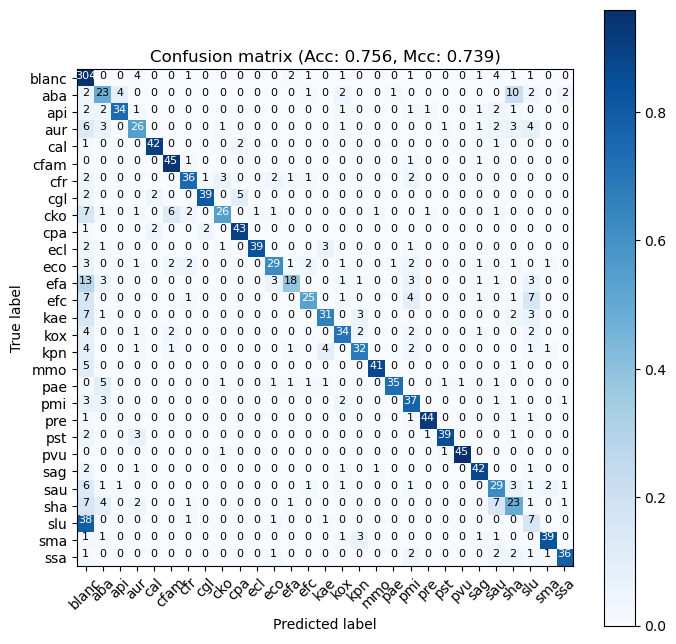

In [8]:
# Make cofusion matrix using sklearn
unique_labels = np.unique(table_0.loc[:, 'labels'])
blanc_class = np.argwhere(unique_labels == 'blanc').flatten()[0]
unique_labels = np.concatenate((['blanc'], np.delete(unique_labels, blanc_class)))
cm = confusion_matrix(table_0.loc[:, 'labels'], table_0.loc[:, 'preds'], labels=unique_labels)
# Display the confusion matrix as a plot
acc = ACC(table_0.loc[:, 'labels'], table_0.loc[:, 'preds'])
mcc = MCC(table_0.loc[:, 'labels'], table_0.loc[:, 'preds'])
# place blancs first


disp = plot_confusion_matrix(cm, unique_labels, acc, mcc)

# Plot the confusion matrix
# plt.plot(cmap=plt.cm.Blues)
# plt.title("Confusion Matrix")
plt.show()

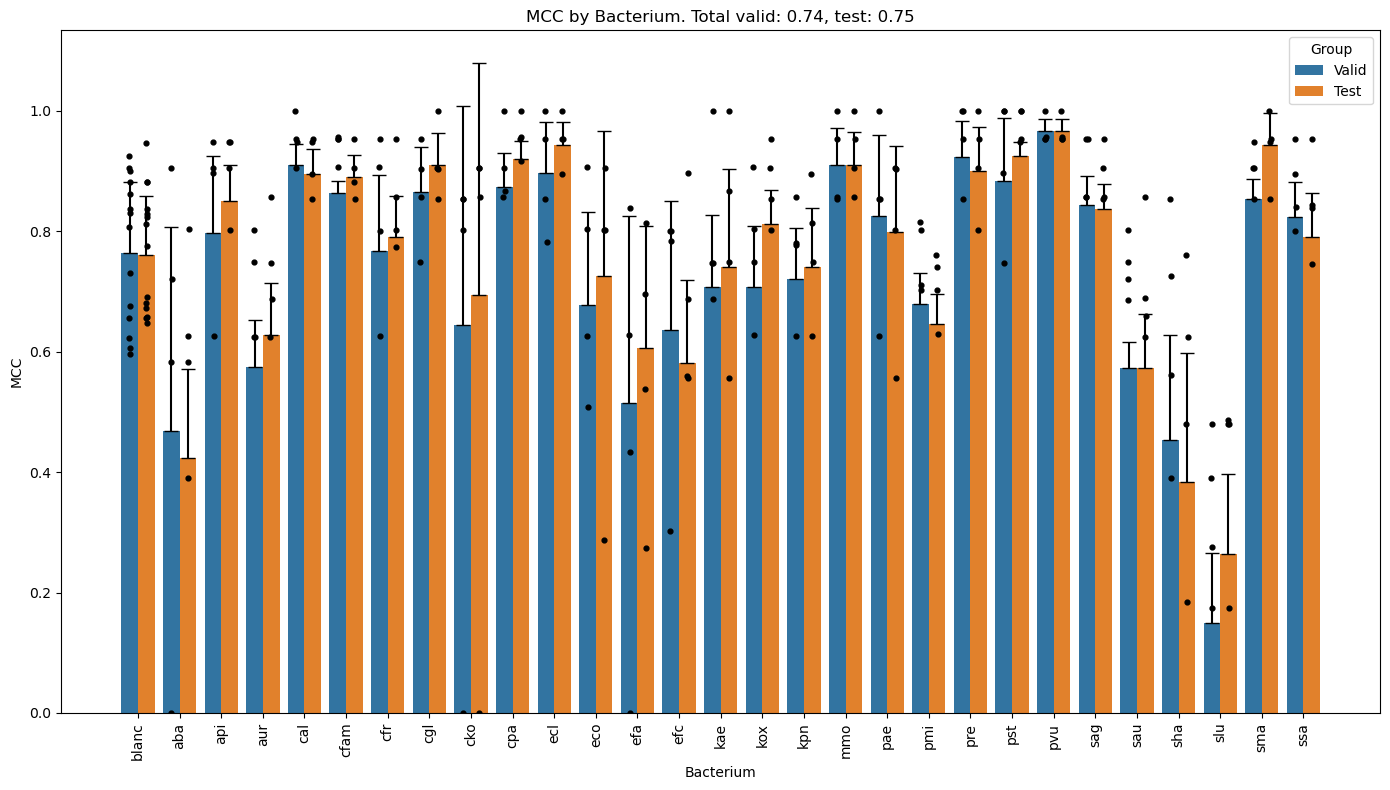

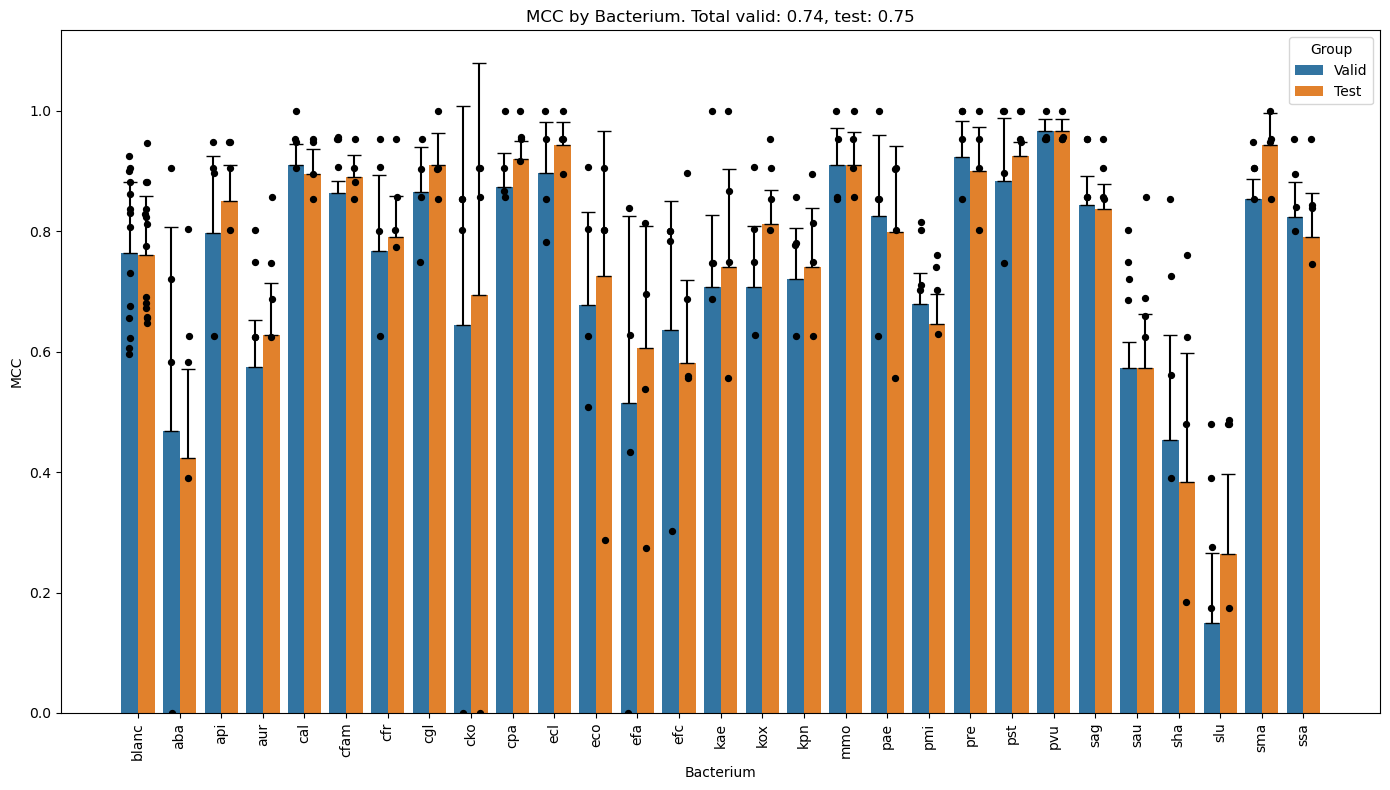

In [9]:
args.post_analysis = 'nothreshold'
plot_bars(args, unique_labels)

# NO THRESHOLD, no slu

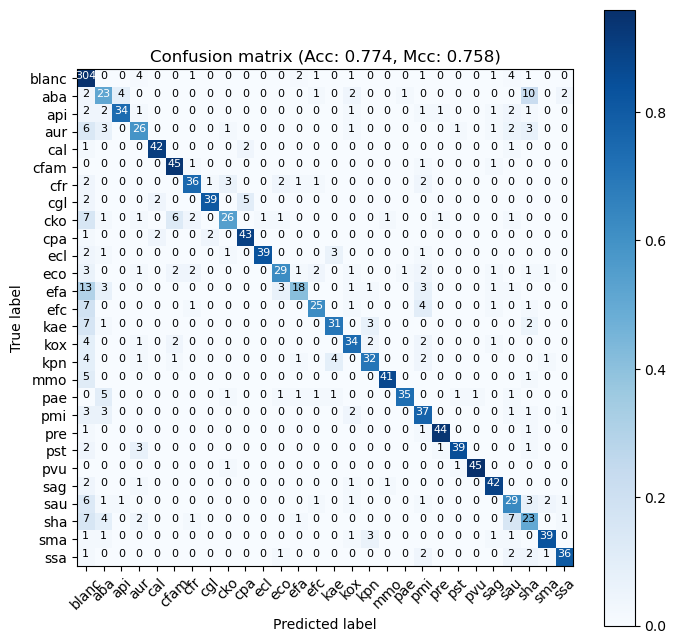

In [10]:
table_0 = table_0[table_0['labels'] != 'slu']
# Make cofusion matrix using sklearn
unique_labels = np.unique(table_0.loc[:, 'labels'])
blanc_class = np.argwhere(unique_labels == 'blanc').flatten()[0]
unique_labels = np.concatenate((['blanc'], np.delete(unique_labels, blanc_class)))
cm = confusion_matrix(table_0.loc[:, 'labels'], table_0.loc[:, 'preds'], labels=unique_labels)
# Display the confusion matrix as a plot
acc = ACC(table_0.loc[:, 'labels'], table_0.loc[:, 'preds'])
mcc = MCC(table_0.loc[:, 'labels'], table_0.loc[:, 'preds'])
# place blancs first


disp = plot_confusion_matrix(cm, unique_labels, acc, mcc)

# Plot the confusion matrix
# plt.plot(cmap=plt.cm.Blues)
# plt.title("Confusion Matrix")
plt.show()

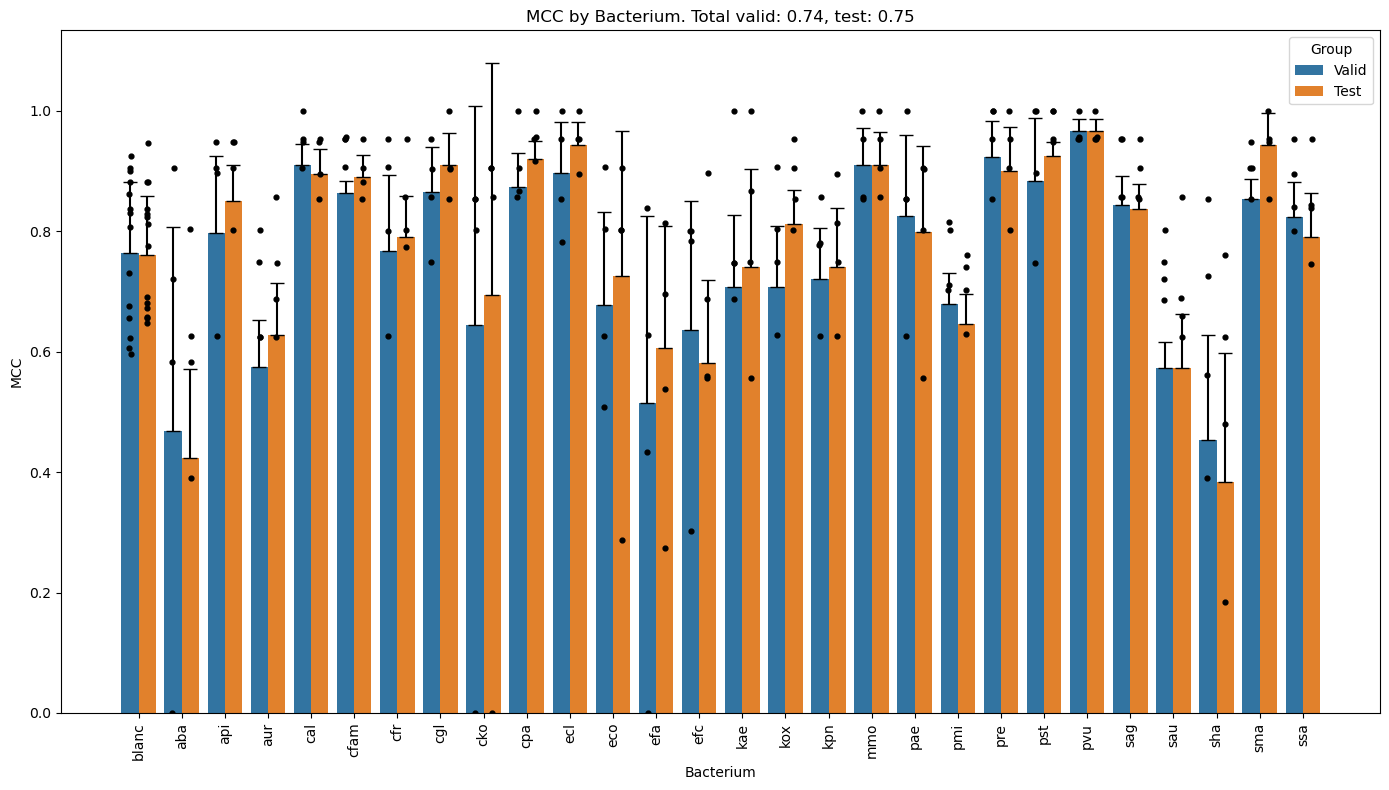

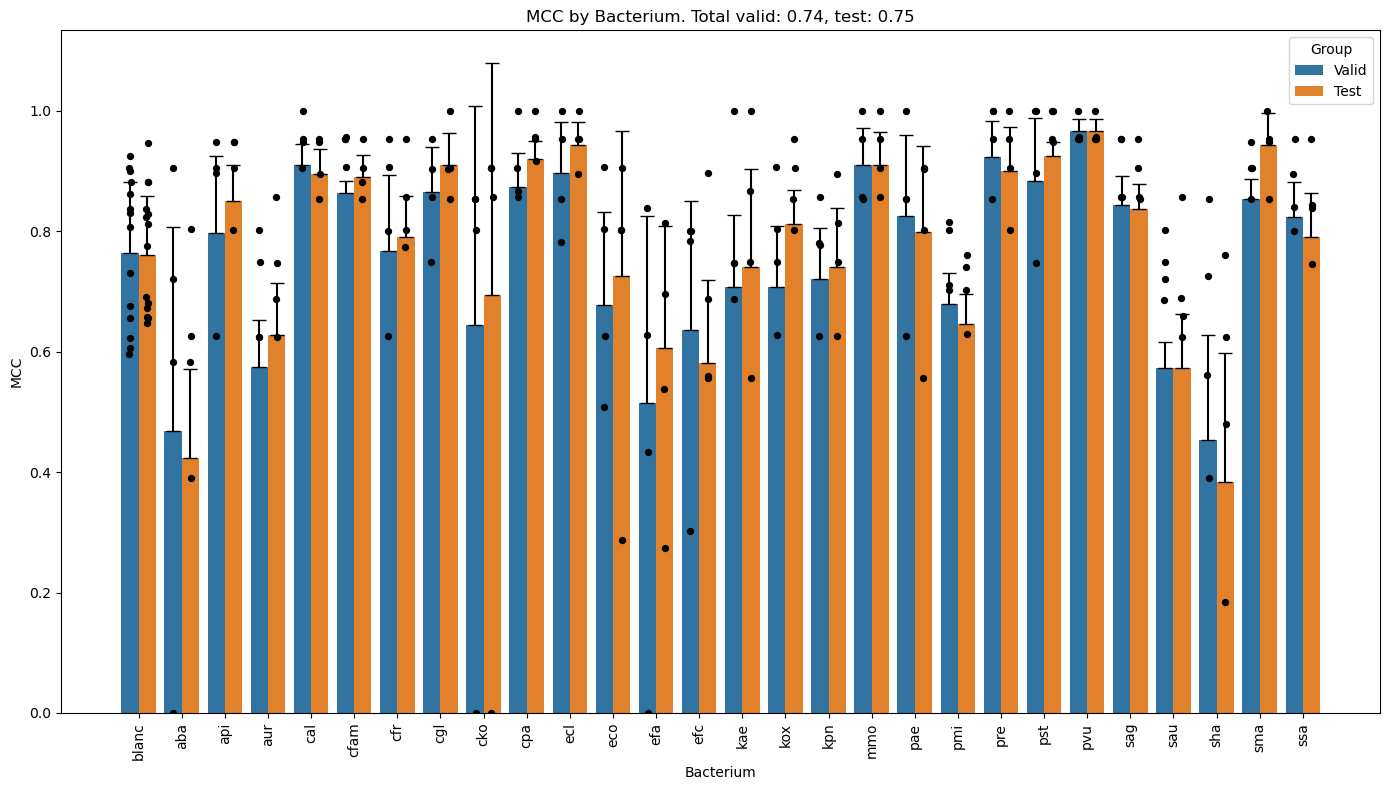

In [11]:
args.post_analysis = 'nothreshold_noslu'
plot_bars(args, unique_labels)

# Threshold at 60%, all classes

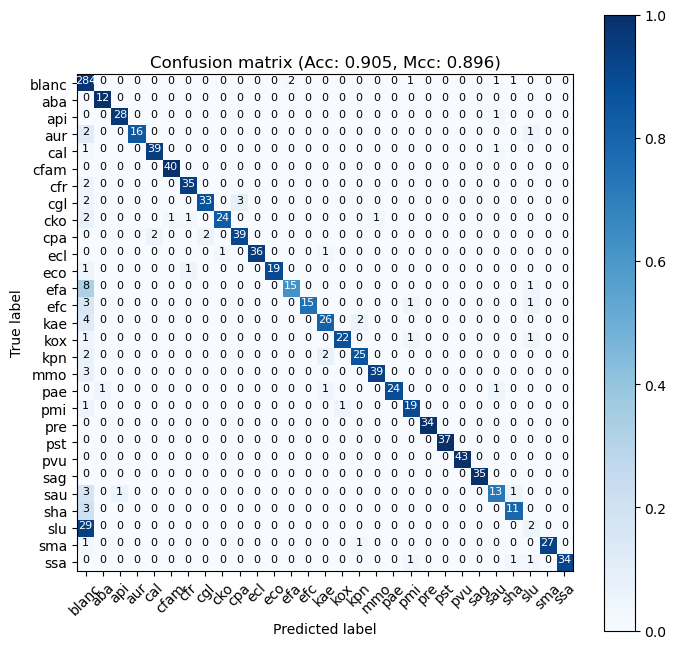

In [12]:
# Make cofusion matrix using sklearn
unique_labels = np.unique(table_06.loc[:, 'labels'])
blanc_class = np.argwhere(unique_labels == 'blanc').flatten()[0]
unique_labels = np.concatenate((['blanc'], np.delete(unique_labels, blanc_class)))
cm = confusion_matrix(table_06.loc[:, 'labels'], table_06.loc[:, 'preds'], labels=unique_labels)
# Display the confusion matrix as a plot
acc = ACC(table_06.loc[:, 'labels'], table_06.loc[:, 'preds'])
mcc = MCC(table_06.loc[:, 'labels'], table_06.loc[:, 'preds'])
# place blancs first


disp = plot_confusion_matrix(cm, unique_labels, acc, mcc)

# Plot the confusion matrix
# plt.plot(cmap=plt.cm.Blues)
# plt.title("Confusion Matrix")
plt.show()

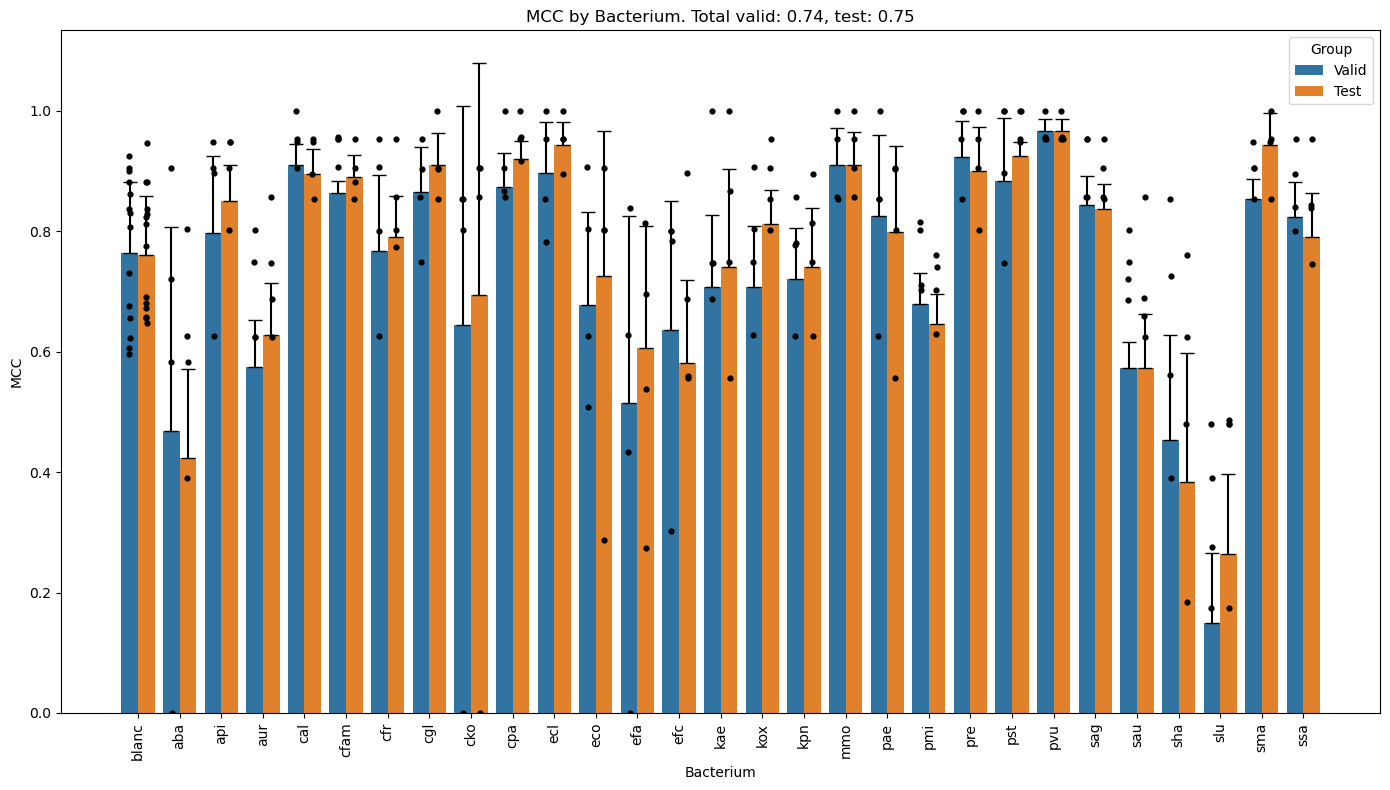

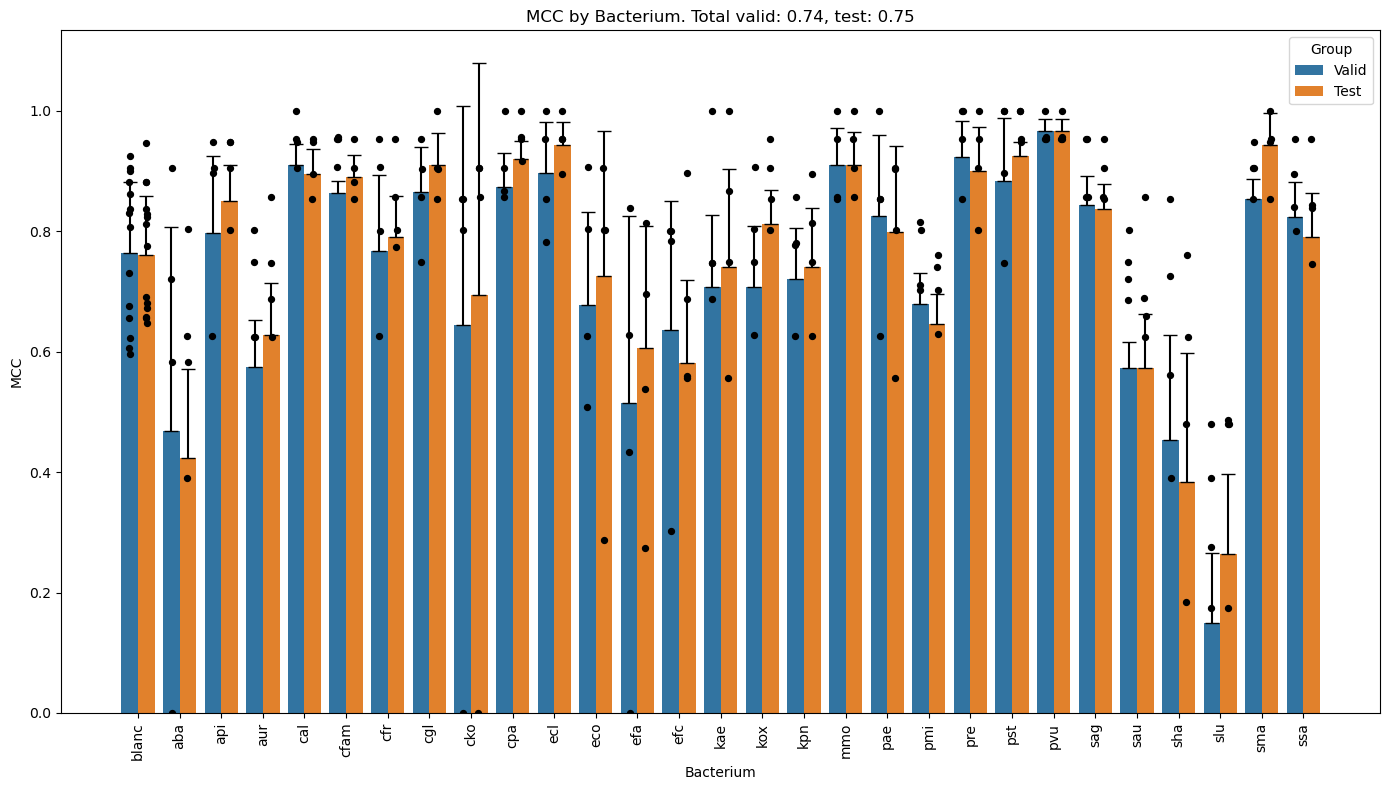

In [13]:
args.post_analysis = 'threshold60'
plot_bars(args, unique_labels)

# Threshold at 60%, no slu

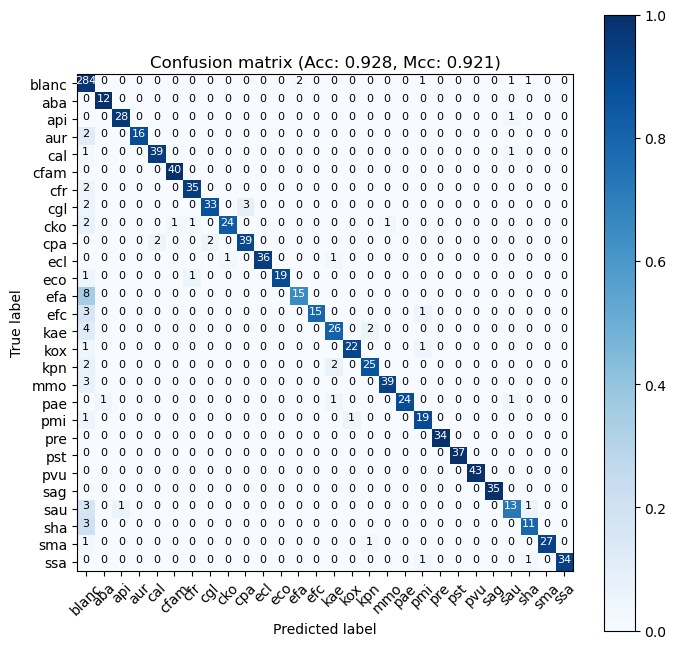

In [14]:
# Remove slu
table_06 = table_06[table_06['labels'] != 'slu']
# Make cofusion matrix using sklearn
unique_labels = np.unique(table_06.loc[:, 'labels'])
blanc_class = np.argwhere(unique_labels == 'blanc').flatten()[0]
unique_labels = np.concatenate((['blanc'], np.delete(unique_labels, blanc_class)))
cm = confusion_matrix(table_06.loc[:, 'labels'], table_06.loc[:, 'preds'], labels=unique_labels)
# Display the confusion matrix as a plot
acc = ACC(table_06.loc[:, 'labels'], table_06.loc[:, 'preds'])
mcc = MCC(table_06.loc[:, 'labels'], table_06.loc[:, 'preds'])
# place blancs first


disp = plot_confusion_matrix(cm, unique_labels, acc, mcc)

# Plot the confusion matrix
# plt.plot(cmap=plt.cm.Blues)
# plt.title("Confusion Matrix")
plt.show()

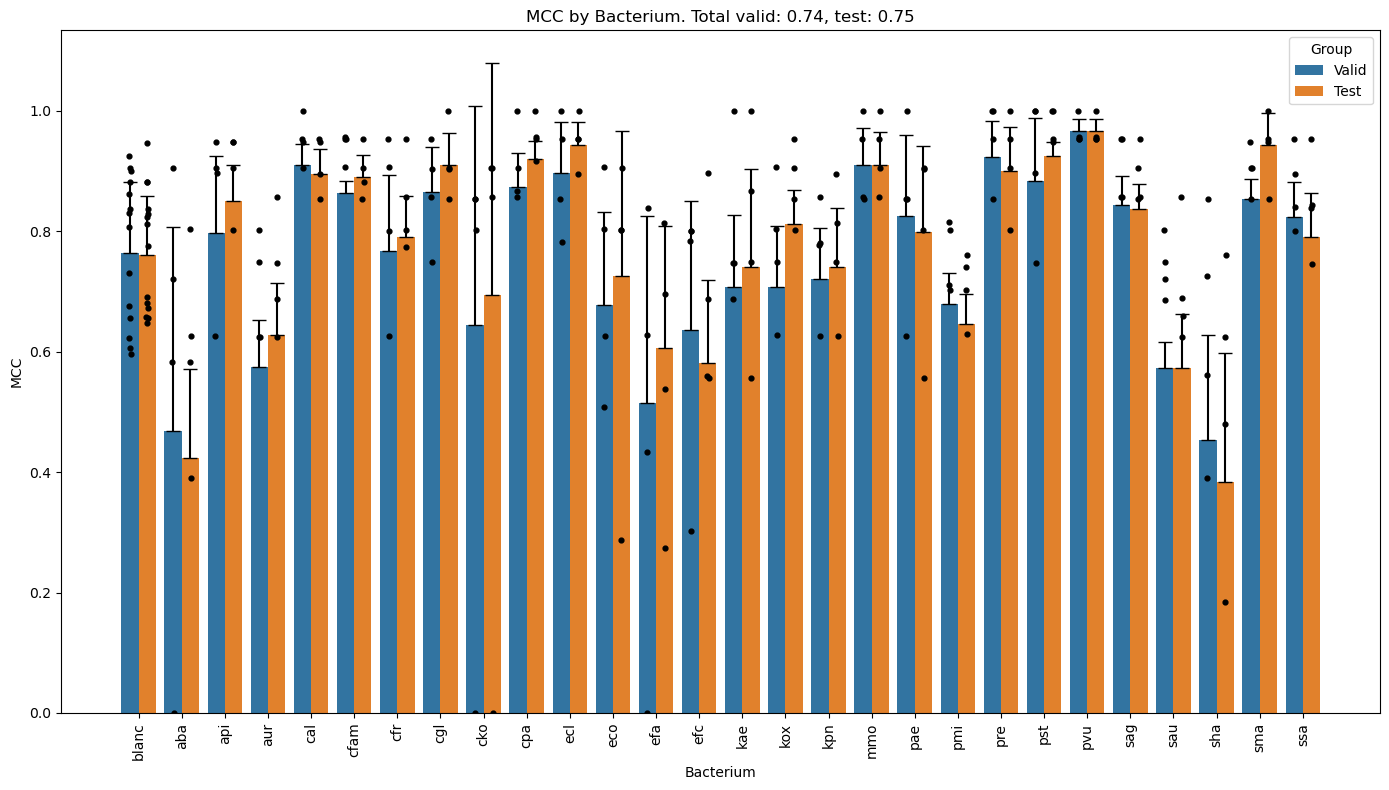

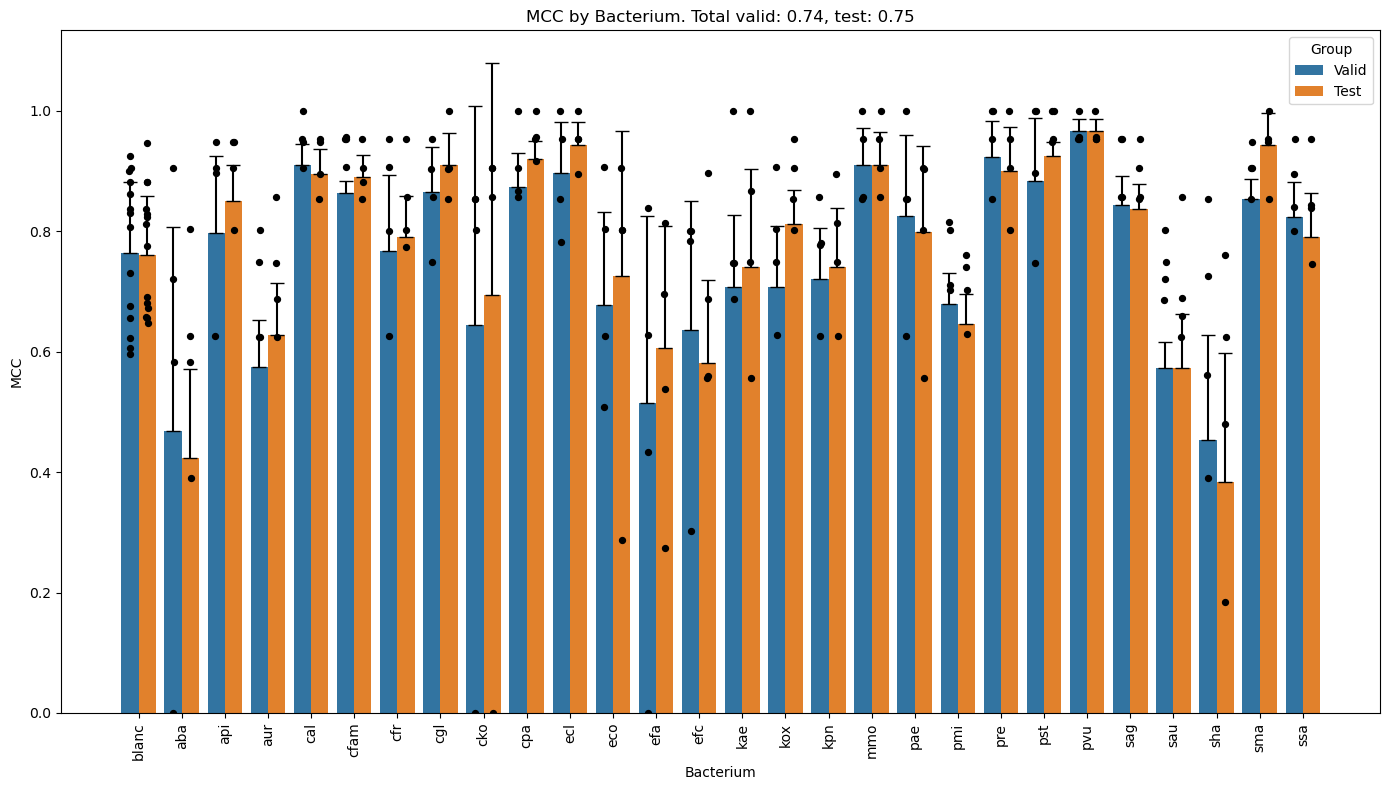

In [15]:
args.post_analysis = 'threshold60_noslu'
plot_bars(args, unique_labels)

In [16]:
args.mz = 6